# Intuit Quickbooks' Mailing Prediction

In [1]:
from math import sqrt

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as sm
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from utils import functions
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
## loading the data
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


## Exploratory Data Analysis

### 1. Check empty data

In [3]:
## statistic
num = intuit75k.select_dtypes(include=np.number).columns.tolist() ## numeric columns
fct = rsm.setdiff(intuit75k.columns,num) ## non-numeric

In [4]:
## check data status - numeric
intuit75k.loc[intuit75k.training==1,fct].agg(['count','nunique']).transpose()

,count,nunique
res1,52500,2
sex,52500,3
zip,52500,6911


- In the `sex` column, some of the sex are unknown
- zip code has 6911 unique value

In [5]:
## check data status - non-numeric
intuit75k.loc[intuit75k.training==1,num].agg(['count','nunique','mean','std','min','max']).transpose()

,count,nunique,mean,std,min,max
id,52500.0,52500.0,37500.368590,21646.602035,1.0,74999.0
zip_bins,52500.0,20.0,10.494019,5.767014,1.0,20.0
bizflag,52500.0,2.0,0.244190,0.429610,0.0,1.0
numords,52500.0,5.0,2.070762,1.239721,1.0,5.0
dollars,52500.0,1065.0,92.681600,80.896686,1.0,1149.0
last,52500.0,36.0,15.856457,9.546888,1.0,36.0
sincepurch,52500.0,36.0,15.616686,10.023926,1.0,36.0
version1,52500.0,2.0,0.213143,0.409532,0.0,1.0
owntaxprod,52500.0,2.0,0.028629,0.166762,0.0,1.0
upgraded,52500.0,2.0,0.207181,0.405290,0.0,1.0


- 20 unique zip bins
- Pay attention to columns have large standard deviation

- there are no null values in the dataset we have

### 2. Visualize the data

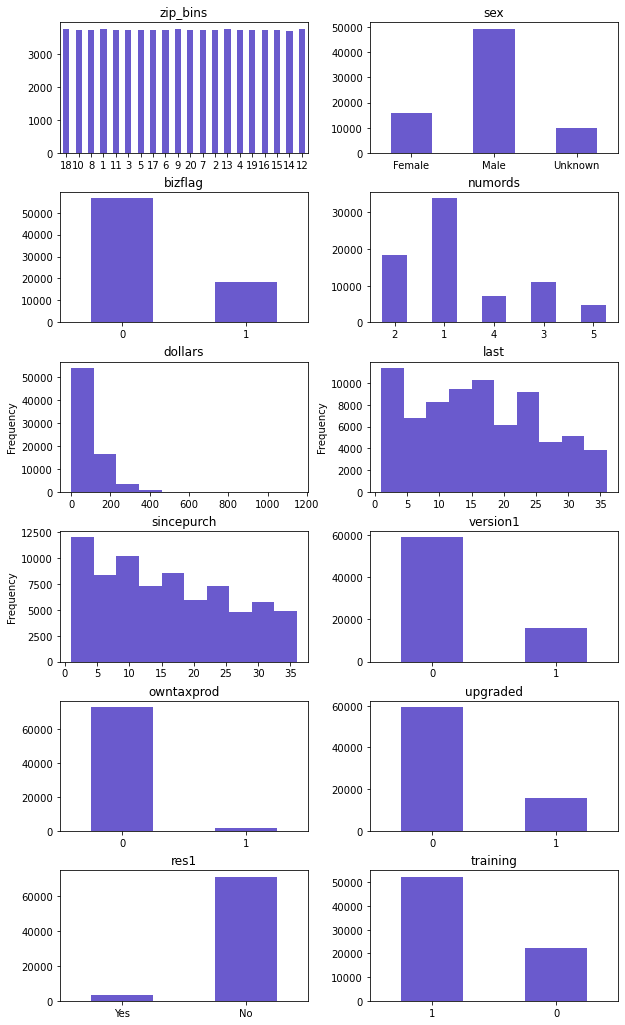

In [6]:
## distribution
rsm.distr_plot(intuit75k.loc[:,'zip_bins':'training'])

### 3. Deep dive to find relationships

<AxesSubplot:xlabel='bizflag', ylabel="Proportion of res1 equal to 'Yes'">

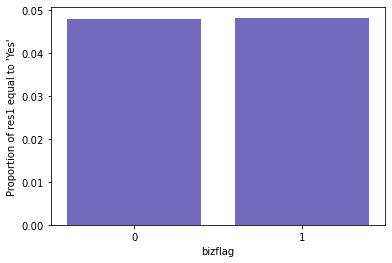

In [7]:
## bizflag-no difference
rsm.prop_plot(intuit75k,'bizflag','res1','Yes')

<AxesSubplot:xlabel='owntaxprod', ylabel="Proportion of res1 equal to 'Yes'">

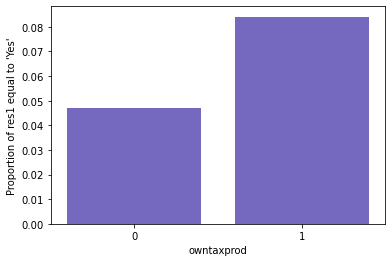

In [8]:
## owntaxprod- 1 has higher response rate
rsm.prop_plot(intuit75k,'owntaxprod','res1','Yes')

<AxesSubplot:xlabel='sex', ylabel="Proportion of res1 equal to 'Yes'">

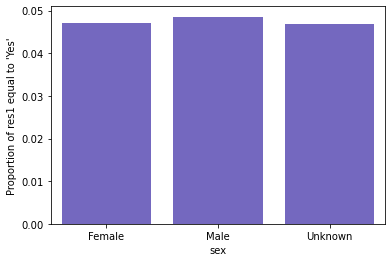

In [9]:
## sex- no obvious difference
rsm.prop_plot(intuit75k,'sex','res1','Yes')

<AxesSubplot:xlabel='upgraded', ylabel="Proportion of res1 equal to 'Yes'">

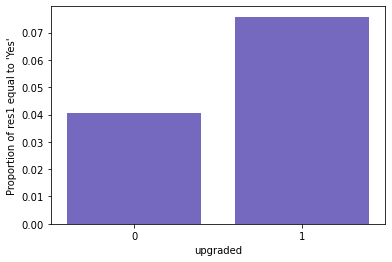

In [10]:
## upgraded- upgraded from 1 to 2 has higher response rate
rsm.prop_plot(intuit75k,'upgraded','res1','Yes')

<AxesSubplot:xlabel='version1', ylabel="Proportion of res1 equal to 'Yes'">

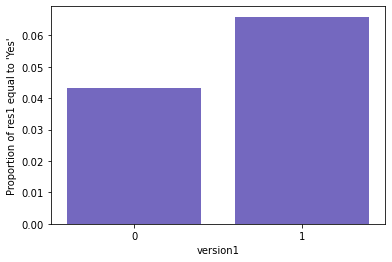

In [11]:
## version1- version1 higher response rate
rsm.prop_plot(intuit75k,'version1','res1','Yes')

<AxesSubplot:xlabel='zip_bins', ylabel="Proportion of res1 equal to 'Yes'">

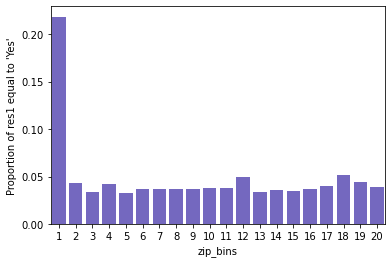

In [12]:
## zip_bins- zip_bins 1 has a higher response
rsm.prop_plot(intuit75k,'zip_bins','res1','Yes')

- we will look further into zip bins

what is going on in the first zip bin

In [13]:
pd.crosstab(
    intuit75k.loc[intuit75k.training==1,'zip'],
    intuit75k.loc[intuit75k.training==1,'res1'],
    normalize='columns'
).sort_values('Yes',ascending=False).apply(
    lambda x: (100*x).round(2).astype(str) + "%"
)

res1,Yes,No
zip,,
00801,19.46%,1.39%
00804,1.8%,0.16%
99999,0.28%,0.87%
30566,0.2%,0.01%
49017,0.16%,0.01%
...,...,...
35209,0.0%,0.0%
35208,0.0%,0.02%
35205,0.0%,0.01%


zipcode 00801 and 00804 are Virgin Islands which includes most overseas military bases, we might ir=mprove the model by adding dummies for zip 00801 and 00804

In [14]:
intuit75k['zip_bins'] = intuit75k.zip_bins.astype('category')
intuit75k = intuit75k.assign(
    zip801 = (intuit75k.zip =='00801').astype(int),
    zip804 = (intuit75k.zip =='00804').astype(int),
)
pred = intuit75k.copy()

In [15]:
## numords
reg = smf.ols(formula='numords ~ res1_yes',data=intuit75k.query("training==1")).fit()
rsm.coef_ci(reg)

,index,coefficient,2.5%,97.5%,p.values,
1,res1_yes,0.523,0.473,0.572,< .001,***


In [16]:
## dollars
reg = smf.ols(formula='dollars ~ res1_yes',data=intuit75k.query("training==1")).fit()
rsm.coef_ci(reg)

,index,coefficient,2.5%,97.5%,p.values,
1,res1_yes,25.533,22.29,28.776,< .001,***


In [17]:
## last
reg = smf.ols(formula='last ~ res1_yes',data=intuit75k.query("training==1")).fit()
rsm.coef_ci(reg)

,index,coefficient,2.5%,97.5%,p.values,
1,res1_yes,-4.026,-4.408,-3.644,< .001,***


In [18]:
## sincepurch
reg = smf.ols(formula='sincepurch ~ res1_yes',data=intuit75k.query("training==1")).fit()
rsm.coef_ci(reg)

,index,coefficient,2.5%,97.5%,p.values,
1,res1_yes,3.712,3.311,4.114,< .001,***


In [19]:
## explore correlations
intuit75k.corr()

,id,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,training,res1_yes,zip801,zip804
id,1.000000,-0.001747,0.004108,0.004658,-0.001073,-0.009943,-0.003996,-0.008849,-0.005966,-0.000009,0.000807,0.002689,-0.002469
bizflag,-0.001747,1.000000,0.000197,0.002038,-0.000390,-0.005220,-0.006011,0.004565,-0.003080,-0.003159,0.000793,0.007191,-0.004104
numords,0.004108,0.000197,1.000000,0.585654,-0.130356,0.001763,0.005728,0.119726,-0.002755,-0.006790,0.093512,-0.007592,-0.001768
dollars,0.004658,0.002038,0.585654,1.000000,-0.074659,0.000815,0.002217,0.074988,-0.001420,-0.007628,0.067876,-0.006172,-0.010586
last,-0.001073,-0.000390,-0.130356,-0.074659,1.000000,-0.001169,0.002018,-0.019854,-0.000192,0.002887,-0.089597,-0.001303,0.001575
sincepurch,-0.009943,-0.005220,0.001763,0.000815,-0.001169,1.000000,0.524144,-0.001149,0.511277,-0.006168,0.078900,-0.000299,0.006892
version1,-0.003996,-0.006011,0.005728,0.002217,0.002018,0.524144,1.000000,-0.084814,-0.267716,-0.003192,0.043701,0.002656,0.006664
owntaxprod,-0.008849,0.004565,0.119726,0.074988,-0.019854,-0.001149,-0.084814,1.000000,0.087418,-0.000593,0.029017,-0.003174,-0.000541
upgraded,-0.005966,-0.003080,-0.002755,-0.001420,-0.000192,0.511277,-0.267716,0.087418,1.000000,-0.004535,0.066733,-0.003025,0.004779
training,-0.000009,-0.003159,-0.006790,-0.007628,0.002887,-0.006168,-0.003192,-0.000593,-0.004535,1.000000,-0.003089,0.002841,-0.001872


Pay attention to sincepurch & version1(0.52) and upgrade (0.51), might lead to multicolinearity

In [20]:
## Interactions
## factors: version1,owntaxprod,upgraded,bizflag
## Number: numords,dollars,last, sincepurch

In [22]:
intuit75k['version1'] = intuit75k.version1.astype('category')
intuit75k['owntaxprod'] = intuit75k.owntaxprod.astype('category')
intuit75k['upgraded'] = intuit75k.upgraded.astype('category')
intuit75k['bizflag'] = intuit75k.bizflag.astype('category')

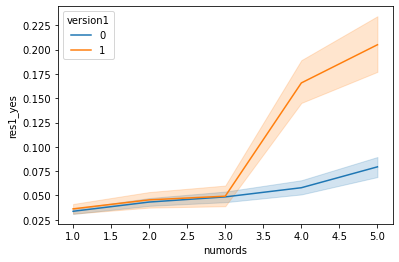

In [25]:
## version1-numords
fig = sns.lineplot(data =intuit75k.query("training==1"), x='numords',y='res1_yes',hue='version1')

When version equals 1, the response rate reacts to the mailing extremetly when the users' number of orders are large -- add numords:version1 interaction

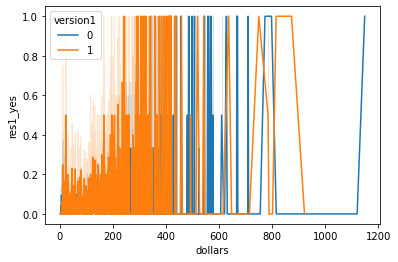

In [26]:
## version1-dollars
fig = sns.lineplot(data =intuit75k.query("training==1"), x='dollars',y='res1_yes',hue='version1')

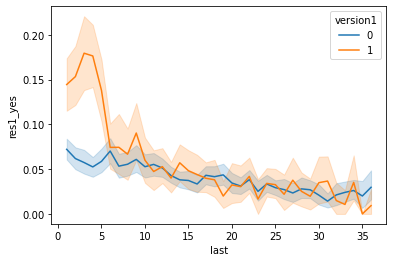

In [27]:
## version1-last
fig = sns.lineplot(data =intuit75k.query("training==1"), x='last',y='res1_yes',hue='version1')

When version equals 1, the response rate reacts to the mailing extremetly when the users' last purchase is near-- add last:version1 interaction

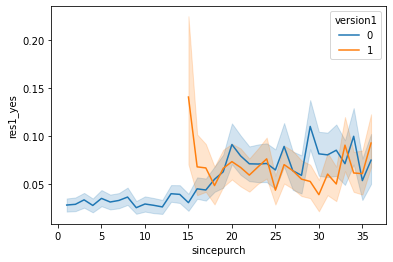

In [28]:
## version1-sincepurch
fig = sns.lineplot(data =intuit75k.query("training==1"), x='sincepurch',y='res1_yes',hue='version1')

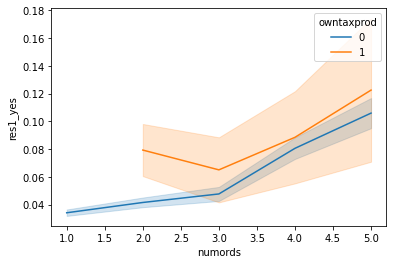

In [29]:
## owntaxprod-numords
fig = sns.lineplot(data =intuit75k.query("training==1"), x='numords',y='res1_yes',hue='owntaxprod')

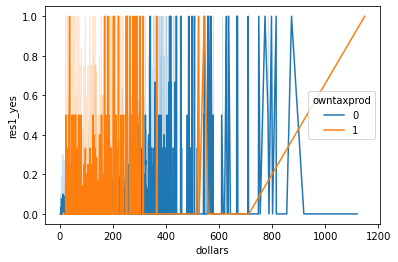

In [30]:
## owntaxprod-dollars
fig = sns.lineplot(data =intuit75k.query("training==1"), x='dollars',y='res1_yes',hue='owntaxprod')

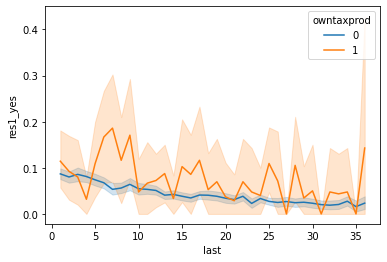

In [31]:
## owntaxprod-last
fig = sns.lineplot(data =intuit75k.query("training==1"), x='last',y='res1_yes',hue='owntaxprod')

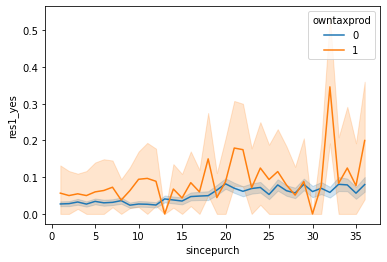

In [32]:
## owntaxprod-sincepurch
fig = sns.lineplot(data =intuit75k.query("training==1"), x='sincepurch',y='res1_yes',hue='owntaxprod')

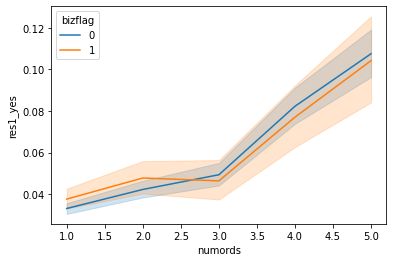

In [37]:
## bizflag-numords
fig = sns.lineplot(data =intuit75k.query("training==1"), x='numords',y='res1_yes',hue='bizflag')

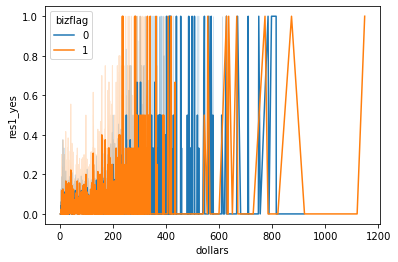

In [38]:
## bizflag-dollars
fig = sns.lineplot(data =intuit75k.query("training==1"), x='dollars',y='res1_yes',hue='bizflag')

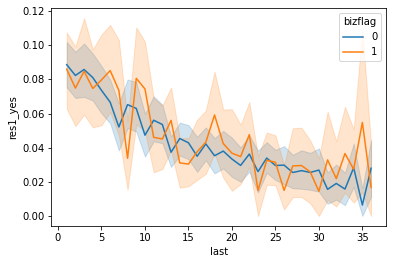

In [39]:
## bizflag-last
fig = sns.lineplot(data =intuit75k.query("training==1"), x='last',y='res1_yes',hue='bizflag')

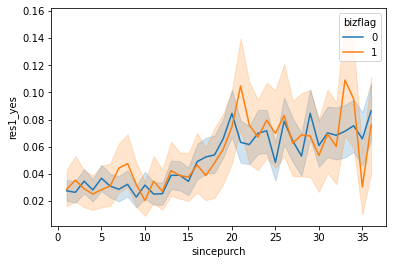

In [40]:
## bizflag-sincepurch
fig = sns.lineplot(data =intuit75k.query("training==1"), x='sincepurch',y='res1_yes',hue='bizflag')

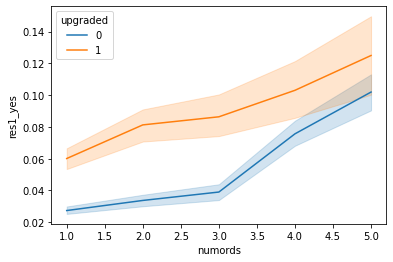

In [33]:
## upgraded-numords
fig = sns.lineplot(data =intuit75k.query("training==1"), x='numords',y='res1_yes',hue='upgraded')

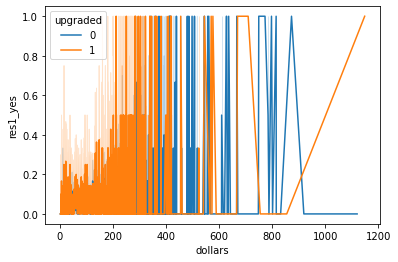

In [34]:
## upgraded-dollars
fig = sns.lineplot(data =intuit75k.query("training==1"), x='dollars',y='res1_yes',hue='upgraded')

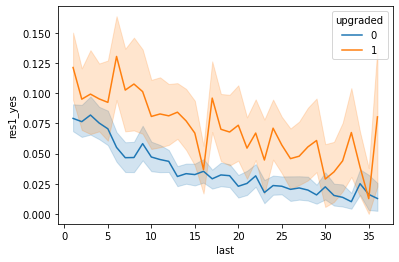

In [35]:
## upgraded-last
fig = sns.lineplot(data =intuit75k.query("training==1"), x='last',y='res1_yes',hue='upgraded')

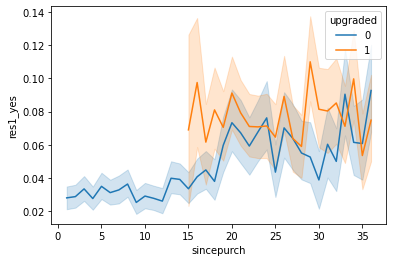

In [36]:
## upgraded-sincepurch
fig = sns.lineplot(data =intuit75k.query("training==1"), x='sincepurch',y='res1_yes',hue='upgraded')

Summary:

- add zipcode 00801 and 00804 dummies
- add interaction numords:version1 and last:version1